In [38]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
np.random.seed(123)


In [3]:
data = pd.read_csv(r'./maps/FVG/FVG_companies.csv', dtype='str')
data.columns = ['ind', 'cf', 'company','unit', 'lat', 'lon']

data['lat'] = data['lat'].astype(float)
data['lon'] = data['lon'].astype(float)
data.shape
data.columns
data.describe

<bound method NDFrame.describe of                                                     ind           cf  \
0                                                   NaN  00079760328   
1     . AUTOPORTO DOGANALE S.LEOPOLDO 4, 33016, PONT...  00521770321   
2     . MARINA DI AURISINA 153/L, 34011, DUINO AURIS...  00968120329   
3                  . SAN ELISEO 21/C, 33030, MAJANO, UD  00325520302   
4     . TANGENZIALE OVEST VIA VENEZIA 1, 33010, TAVA...  00991520305   
...                                                 ...          ...   
7950  ZONA INDUSTRIALE UDINESE, 33050, PAVIA DI UDIN...  00992960302   
7951  ZONA INDUSTRIALE VIA REMIS 17, 33050, SAN VITO...  02069870307   
7952  ZONA INDUSTRIALE VIA S. MARCO 17, 33099, VIVAR...  00412260937   
7953               ZONA INDUSTRIALE, 33085, MANIAGO, PN  01041280932   
7954             ZONA LISERT S/N, 34074, MONFALCONE, GO  01523580304   

                                               company   unit        lat  \
0                        

In [4]:
def plot_clusters(X, cluster_labels, centroids):
    _, ax = plt.subplots(figsize=(6, 6))
    for i in np.unique(cluster_labels):
        cluster_points = X[cluster_labels == i , :]        
        centroid = centroids[i , :]
        plt.scatter(cluster_points[:,0] , cluster_points[:,1] , cmap = i, marker='.')
        plt.scatter(centroid[0] , centroid[1] , c = 'black', marker='*', s=60)  

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Visualization of clustered data', fontweight='bold')
    ax.set_aspect('equal')
    plt.show

(7955, 2)


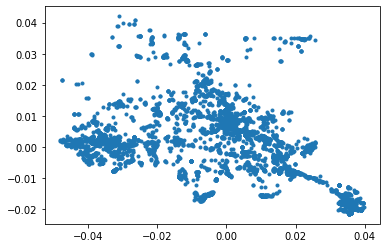

In [5]:
X = np.array(data[ ['lon','lat'  ] ]) 
X = (X - X.mean(axis=0))/X.std()
print(X.shape)
plt.scatter(X[:,0] , X[:,1] ,  marker='.')


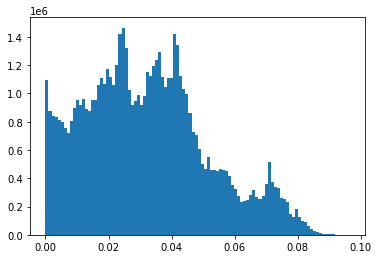

In [6]:
#compute the minimum distances of the k-th nearest neighbour
from scipy.spatial import distance_matrix
dm = distance_matrix(X,X)
values = np.reshape(dm,-1)
plt.hist(values, bins = 100)
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

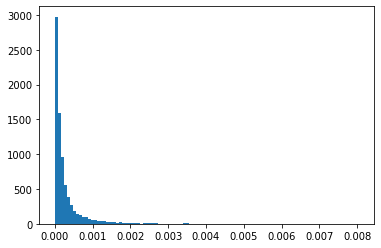

In [7]:
knn = 5
min_distances= np.partition(dm, knn, axis=0)[knn] 
plt.hist(min_distances, bins = 100)
plt.show

In [8]:
for p in range(10,100,10):
    print(f"il {p}° percentile ==> distanza {np.percentile(min_distances, p)}")

il 10° percentile ==> distanza 0.0
il 20° percentile ==> distanza 3.8689049631348505e-05
il 30° percentile ==> distanza 6.132700849849182e-05
il 40° percentile ==> distanza 8.951159880845663e-05
il 50° percentile ==> distanza 0.00012759409635238196
il 60° percentile ==> distanza 0.0001779280182503598
il 70° percentile ==> distanza 0.000246781844279257
il 80° percentile ==> distanza 0.0003740352486409508
il 90° percentile ==> distanza 0.0007036251123530892


In [9]:
dm = distance_matrix(X,X)
index = 2
distances = dm[index]

epsilon = .02
minPoints= 40

distances_epsilon = distances[ distances <= epsilon]



In [21]:
def epsilon_neighborhood(p, epsilon):
    distances = dm[p]
    distances_epsilon = distances[ distances <= epsilon]
    nn = len(distances_epsilon)
    neighbours_indices = np.argpartition(distances_epsilon, nn-1, axis=0)
    return neighbours_indices

def is_core(p, epsilon, minPoints):
    nbhood =  epsilon_neighborhood(p, epsilon)
    return (len(nbhood) >= minPoints)

def is_directly_density_reachable(p,q, epsilon, minPoints):
    '''An object q is directly density-reachable from object p 
    if q is within the ε-Neighborhood of p 
    and p is a core object'''
    is_ddr = False
    if is_core(p, epsilon, minPoints):
        if (q in epsilon_neighborhood(p, epsilon)):
            is_ddr = True
    return is_ddr




In [11]:
# for eps in [.0001, .002, .005, .01, .1]:
#     nbhood = epsilon_neighborhood(1, eps)
#     print(len(nbhood), is_core(1, eps, 5))


In [12]:
# epsilon = .005
# minPoints = 15
# for p in range(10):
#     for q in range(10):
#         tmp = is_directly_density_reachable(p,q, epsilon, minPoints)
#         print(tmp)

In [44]:
#retrieva all points density reachable from P

def density_reachable(points, p, epsilon, minPoints):
    density_reachable = []
    candidates = list(points)
    candidates.remove(p)
    while(len(candidates)> 0):
        print("*candidates*",max(candidates))
        for q in candidates:
            if is_directly_density_reachable(p,q, epsilon, minPoints):
                density_reachable.append(q)
                print(density_reachable)
                
                #print(q)
    ## ERRORE restituisco gli indici dei candidati, mentre dovrei restituire gli indici originali di X 
    
    return density_reachable

epsilon = .01
minPoints = 20
n_points = len(X)
indexes = list(np.arange(n_points)) 
dr = density_reachable(indexes, 7000, epsilon, minPoints)
len(dr)


*candidates* 7954
[0]
[0, 2]
[0, 2, 4]
[0, 2, 4, 6]
[0, 2, 4, 6, 8]
[0, 2, 4, 6, 8, 10]
[0, 2, 4, 6, 8, 10, 12]
[0, 2, 4, 6, 8, 10, 12, 14]
[0, 2, 4, 6, 8, 10, 12, 14, 16]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 

469

In [14]:
#dbscan
epsilon = .002
minPoints = 10
n_points = len(X)
all_points = list(np.arange(n_points)) 
clusters = np.zeros(n_points)

cluster_id = 0
points_to_visit = len(all_points)

while(points_to_visit > 0):
    p = np.random.choice(all_points)
    all_points.remove(p)
    points_to_visit = len(all_points)

    #print(p, len(all_points))
    if is_core(p, epsilon, minPoints):
        cluster_id += 1
        indexes = density_reachable(list(all_points), p, epsilon, minPoints)
        # restituisce gli indici sbagliati... dovrei dare gli indici originali di X
        print("ddr points", all_points[indexes])
        clusters[indexes] = cluster_id
        [all_points.remove(i) for i in indexes]
    else:
        pass# print(len(points))
    
    print(len(all_points))



 



TypeError: list indices must be integers or slices, not list

{0.0, 1.0}

In [ ]:
#radius of the circle 
eps = 0.0015

#minimum neighbouring points set to 3
minPts = 25


In [ ]:
#radius of the circle 
eps = 0.0015

#minimum neighbouring points set to 3
minPts = 25


# my DBSCAN class


In [ ]:
class DBSCANClustering():
    def __init__(self, X,  epsilon=.01, minPoints = 15 ):
        assert epsilon > 0 
        self.epsilon = epsilon
        assert minPoints > 2
        self.minPoints = minPoints
        self.n_points = X.shape[0]
        self.dimensions = X.shape[1]
        
        from scipy.spatial import distance_matrix
        self.dm = distance_matrix(X,X)
    
    def epsilon_neighborhood(self,index):
        distances = self.dm[index]
        distances_epsilon = distances[ distances <= self.epsilon]
        if len(distances_epsilon) > self.minPoints:
            neighbours_indices = np.argpartition(distances_epsilon, self.minPoints, axis=0)[:self.minPoints]
        else:
            neighbours_indices=np.array(0)
        return neighbours_indices
    
    def is_core(self,index):
        if len(epsilon_neighborhood(index)) >= self.minPoints 
            return True
        else 
            return False
    
    def is_directly_density_reachable(self,p,q):
        '''An object q is directly density-reachable from object p 
        if q is within the ε-Neighborhood of p 
        and p is a core object'''
        if is_core(p):
            if (q is epsilon_neighborhood(p)):
                return True
            else:
                return False
        
    def is_density_reachable(self,index):
        return
    
    def is_core(self,index):
        """
        Args:
            df (pandas dataframe): data points
            index (int): index of the point to be classified
           
        Returns:
            tuple: dataframe (index, is_core, is_border, is_noise)
        """
        distances = self.dm[index]
        neighbours_indices = np.argpartition(distances, self.minPoints, axis=0)[:self.minPoints] 
        
        neighbours = distances[neighbours_indices]
        neighbours_within_epsilon = neighbours[ neighbours < self.epsilon]
        
        if len(neighbours_within_epsilon) == 0: 
            # is halo
            return (neighbours_indices , False, False, True)
        elif len(neighbours_within_epsilon) >= self.minPoints: 
            # is core
            return (neighbours_indices , True, False, False)
        else:
            # is border
            return (neighbours_indices , False, True, False)
        
    
    def fit(self,X):
        '''
        – select a point p
        – Retrieve all points density-reachable from p wrt  and MinPts.
        – If p is a core point, a cluster is formed.
        – If p is a border point, no points are density-reachable from p and
        DBSCAN visits the next point of the database.
        – Continue the process until all of the points have been processed.
'''
        # compute distance matrix for ALL points
        # simple but not optimized for memory: stores the whole matrix.
        from scipy.spatial import distance_matrix
        self.dm = distance_matrix(X,X)
        
        # initialize all points to halo (label = 0)
        self.clusters = np.zeros(self.n_points) 
        C = 1
        
        current_stack = set()
        unvisited = list(np.arange(self.n_points))#list(df.index)
        clusters = []
        print('Processinng cluster ', C)
        while (len(unvisited) > 0): #run until all points have been visited
            
            #identifier for first point of a cluster
            first_point = True
            
            #choose a random unvisited point
            current_stack.add(random.choice(unvisited))
                        
            while len(current_stack) > 0: #run until a cluster is complete
                
                #pop current point from stack
                curr_idx = current_stack.pop()
                              
                #check if point is core, neighbour or border
                neigh_indexes, iscore, isborder, isnoise = self.is_core(curr_idx)
                
                #dealing with an edge case
                if (isborder & first_point):
                    print("Debug: isborder and first")
                    #for first border point, we label it aand its neighbours as noise 
                    clusters.append((curr_idx, 0))
                    clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                    
                    #label as visited
                    unvisited.remove(curr_idx)
                    unvisited = [e for e in unvisited if e not in neigh_indexes]

                    continue
                    
                unvisited.remove(curr_idx) #remove point from unvisited list
                
                
                neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
                
                if iscore: #if current point is a core
                    first_point = False
                    
                    clusters.append((curr_idx,C)) #assign to a cluster
                    current_stack.update(neigh_indexes) #add neighbours to a stack

                elif isborder: #if current point is a border point
                    clusters.append((curr_idx,C))
                    
                    continue

                elif isnoise: #if current point is noise
                    clusters.append((curr_idx, 0))
                    
                    continue
                    
            if not first_point: 
                C+=1
                print('Processinng cluster ', C)
                
        self.clusters = clusters
        return clusters
        

SyntaxError: invalid syntax (<ipython-input-167-a1b1f741c68a>, line 23)

# Clustering

In [ ]:
#radius of the circle 
eps = 0.0015

#minimum neighbouring points set to 3
minPts = 25


In [ ]:
clusters_with_halo = DBSCANClustering(X, epsilon=eps, minPoints = minPts )
cc = clusters_with_halo.fit(X)

Processinng cluster  1
Processinng cluster  2
Debug: isborder and first
Processinng cluster  3
Debug: isborder and first
Processinng cluster  4
Processinng cluster  5
Debug: isborder and first
Processinng cluster  6
Debug: isborder and first
Debug: isborder and first
Processinng cluster  7
Processinng cluster  8
Processinng cluster  9
Processinng cluster  10
Processinng cluster  11
Processinng cluster  12
Debug: isborder and first
Processinng cluster  13
Debug: isborder and first
Processinng cluster  14
Debug: isborder and first
Debug: isborder and first
Processinng cluster  15
Debug: isborder and first
Debug: isborder and first
Debug: isborder and first
Processinng cluster  16
Debug: isborder and first
Processinng cluster  17
Processinng cluster  18
Processinng cluster  19
Processinng cluster  20
Debug: isborder and first
Debug: isborder and first
Debug: isborder and first
Debug: isborder and first
Processinng cluster  21
Debug: isborder and first
Debug: isborder and first
Processinng

In [ ]:
dd=pd.DataFrame(cc, columns=["point","cluster"])
dd

,point,cluster
0,6679,1
1,4431,1
2,4114,1
3,146,1
4,6677,1
...,...,...
9671,6099,0
9672,6077,0
9673,6082,0
9674,5957,0


In [ ]:
len(set(dd.cluster))

60

In [ ]:
len(set(dd.point)) 

(7955, 7955)

In [ ]:
dd.to_csv('test_clusters.csv', index=False)

In [ ]:
pd.pivot_table(dd, values='cluster', index='point', aggfunc='count')

,cluster
point,
0,2
1,1
2,1
3,2
4,1
...,...
7950,1
7951,1
7952,1


In [ ]:
dd.drop_duplicates()

,point,cluster
0,6679,1
1,4431,1
2,4114,1
3,146,1
4,6677,1
...,...,...
9646,1606,0
9647,4440,0
9648,7107,0
9649,4620,0


In [ ]:
pts = list(zip(*cc))[0] 
clst = list(zip(*cc))[1] 
test = pd.DataFrame()
test['pts']=pts
test['clst']=clst
halo = test[ test.clst == 0 ]


#ERRORE CI SONO DUPLICATI! chi? il primo/ultimo? Halo?

In [ ]:
len(halo.pts), len(set(halo.pts))

(2730, 2062)

In [ ]:
clusters NON deve essere una lista (.append)
ma una matrice index / value

In [ ]:
cluster_df.to_csv(r'./data/FVG_comp_clusters.csv')
cluster_df.shape

NameError: name 'cluster_df' is not defined

In [ ]:
cluster_df = pd.DataFrame(cc, columns = ["idx", "cluster"])
cluster_labels1 = cluster_df["cluster"]
np.unique(cluster_labels1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

Text(0, 0.5, 'Y')

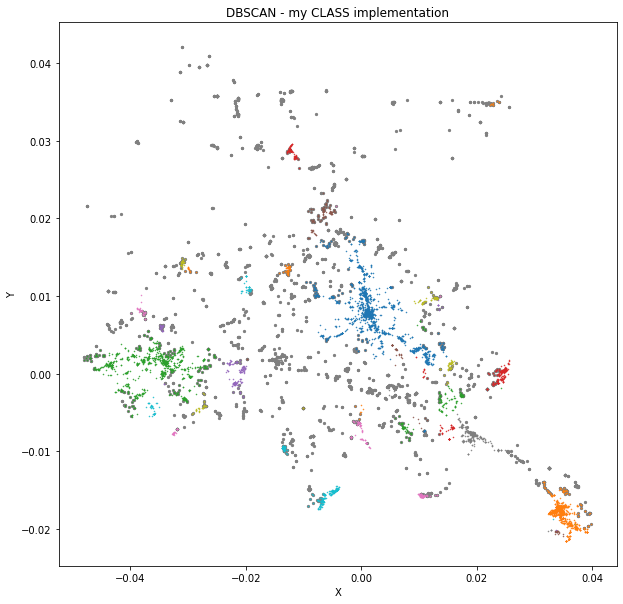

In [ ]:


plt.figure(figsize=(10,10))
for clust in np.unique(cluster_labels1):
    if clust == 0: 
        plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], 
                    X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], 
                    s=20, marker = ".", color = "gray",
                    label="halo")
    else:
        plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], 
            X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], 
            s=1, marker = ".", 
            label=f"Cluster{clust}")


#plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
#plt.legend()
plt.title('DBSCAN - my CLASS implementation')
plt.xlabel('X')
plt.ylabel('Y')

In [ ]:
data.shape

(7955, 6)

In [ ]:
cluster_df.shape

(9642, 2)